In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
# from scipy.optimize import curve_fit
# from pathlib import Path
# import pickle

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [4]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/projects/2017-kohl/OASIS'))
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2

/home/zenke/projects/2017-kohl/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [5]:
# Import local tools
sys.path.append(os.path.expanduser('~/projects/2017-kohl/repo/'))
from pynalysis import utils

In [6]:
import cv2

cap = cv2.VideoCapture("/home/zenke/data/kohl/videos/CTBD1.3g/CTBD13g-area02-20180805-30a-30p_0001.avi")
# print ("open  = ",cap.isOpened())

frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))


capture_count = frameCount
rgb_buf = np.empty((capture_count, frameHeight, frameWidth, 3), np.dtype('uint8'))

for fc in tqdm.trange(capture_count):
    ret, rgb_buf[fc] = cap.read()
    if not ret: break

cap.release()

buf = rgb_buf[:,:,:,0]
del rgb_buf

100%|██████████| 29955/29955 [01:33<00:00, 319.55it/s]


In [7]:
import hickle
f = open('/home/zenke/data/kohl/videos/CTBD1.3g/CTBD13g-area02-20180805-30a-30p_0001.hkl', 'w')
hickle.dump(buf, f)

In [8]:
# import pickle
# f = open('/home/zenke/data/kohl/videos/CTBD1.3g/CTBD13g-area01-20180805-30a-30p_0001.pkl', 'w')
# pickle.dump(buf, f)

In [9]:
print(fps)

30


In [10]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, NMF

In [11]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

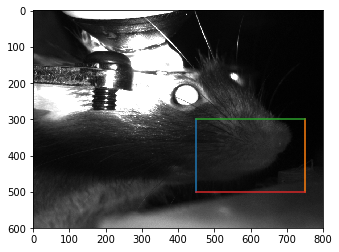

In [12]:

plt.imshow(buf.reshape((-1,600,800))[1375], cmap=plt.cm.gray)
plt.plot([450,450],[300,500])
plt.plot([750,750],[300,500])
plt.plot([450,750],[300,300])
plt.plot([450,750],[500,500])

In [13]:
cut = buf[:5000,300:500,450:750]
osh = cut.shape
X = cut.reshape((cut.shape[0],-1))

In [14]:
X = (X-X.mean(0))/(X.std(0)+1e-3)

In [15]:
pca = PCA(n_components=100)
Xred = pca.fit_transform(X)
# method = FastICA(n_components=20)
# method = NMF(n_components=20)

In [ ]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(Xred)

In [ ]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])

In [ ]:
fig=plt.figure(figsize=(16,12))
a=5
for i in range(np.min((a**2,method.n_components))):
    plt.subplot(a,a,1+i)
    plt.imshow(method.components_[i].reshape(*osh[1:]), plt.cm.gray)

In [ ]:
y = method.transform(X)
Xhat = method.inverse_transform(y)

In [ ]:
gs = GridSpec(1,2)
plt.subplot(gs[0])
plt.imshow(X.reshape(osh)[123])
plt.subplot(gs[1])
plt.imshow(Xhat.reshape(osh)[123])

In [ ]:
p0=plt.plot(y)

In [ ]:
cut_all = buf[:,300:500,450:750]
X_all = cut_all.reshape((cut_all.shape[0],-1))
whisker_components = method.transform(X_all)
del buf # free memory

In [ ]:
# plt.plot(pca.explained_variance_ratio_)

In [ ]:
print(1/0)

In [ ]:
def plot_event(dp,event_name,y_offset=0,**kwargs):
    x = dp["events"][event_name]/dp["frate"]
    y = y_offset*np.ones(len(x))
    plt.scatter(x,y,label=event_name,**kwargs)

In [ ]:
def bin_data(data,bs=5):
    """ Bin data along first axis. 
    
    # Args
    data - The data array
    bs - The bin size 
    
    # Returns
    Array with same dimensions as data exept the one which was binned.
    """
    shape = list(data.shape)
    shape[0] = shape[0]//bs 
    binned = np.zeros(shape)
    for b in range(shape[0]):
        binned[b] = data[b*bs:(b+1)*bs].sum(0)
    return binned

def bin_events(dp,event_name,nb_bins=100,bs=5):
    events = np.array(dp["events"][event_name],dtype=int)//bs
    binned = np.zeros(nb_bins)
    for e in events:
        binned[e] += 1
    return binned

In [ ]:
t = np.arange(-500,500+1)
kernel = np.exp(-(t/10)**2)
plt.plot(t,kernel)
sns.despine()

In [ ]:
dp=packs[-3]
print(dp["hdf5path"])
print(dp["frate"])

In [ ]:
# resample whisker data
from scipy.signal import resample

In [ ]:
whisker_components.shape

In [ ]:
nb_resamples = int(whisker_components.shape[0]*dp["frate"]/fps)

In [ ]:
print(nb_resamples)

In [ ]:
whisk = resample(whisker_components, nb_resamples)

In [ ]:
whisk.shape

In [ ]:
p0=plt.plot(np.arange(len(whisker_components))/fps, whisker_components[:,1])
p0=plt.plot(np.arange(len(whisk))/dp["frate"],whisk[:,1])

In [ ]:
pln=0
bs=1

bspk = bin_data(dp["planes"][pln]["spikes"],bs=bs)
blck = bin_events(dp,"licks",bspk.shape[0],bs=bs)
bstt = bin_events(dp,"motor_start",bspk.shape[0],bs=bs)
bcor = bin_events(dp,"correct",bspk.shape[0],bs=bs)
bcrr = bin_events(dp,"correct_rejection",bspk.shape[0],bs=bs)

t = np.arange(len(bspk))/dp["frate"]*bs

gs = GridSpec(5,1,height_ratios=[1,1,1,3,3])

plt.figure(figsize=(16,6))
a0 = plt.subplot(gs[0])
p0=plt.plot(t,np.convolve(blck,kernel,mode="same"))
plt.ylabel("Lick rate")


ax = plt.subplot(gs[1], sharex=a0)
bvel = dp["events"]["velocity"].ravel()
p1=plt.plot(t,np.convolve(bvel,kernel,mode="same"))
plt.ylabel("velocity")


ax = plt.subplot(gs[2], sharex=a0)
p1=plt.plot(t,np.convolve(bstt,kernel,mode="same"))
plt.ylabel("start")

ax = plt.subplot(gs[3], sharex=a0)
plt.ylabel("spikes")
for tr in bspk.T:
    spkflt=np.convolve(tr,kernel,mode="same")
    p1=plt.plot(t,spkflt)
    
ax = plt.subplot(gs[4], sharex=a0)
plt.ylabel("whisk")
for tr in whisk.T:
    t = np.arange(len(tr))/dp["frate"]*bs
    spkflt=np.convolve(tr,kernel,mode="same")
    p1=plt.plot(t,spkflt)

ax.set_xlabel("Time (s)")
# plot_event(dp,"licks",1400)
sns.despine()
# plt.xlim(0,1200)

In [ ]:
t[-1]

In [ ]:
fields = [blck, bvel, bcor]
fields.extend(whisk.T)
fields.extend(bspk.T)
ln = np.min([ len(f) for f in fields ])
print(ln)
# fields.extend(bspk.T)
X = np.concatenate([ np.convolve(f[:ln],kernel,mode="same").reshape((-1,1)) for f in fields ], axis=1)
print(X.shape)
C = np.corrcoef(X.T)
plt.imshow(C)
plt.colorbar()

In [ ]:
def ravel_offd(mat):
    el = []
    for i in range(mat.shape[0]):
        for j in range(i+1,mat.shape[1]):
            el.append(mat[i,j])
    return el

In [ ]:
ravel_offd(C[:3,:3])

In [ ]:
from scipy.stats import kurtosis,skew 

def plot_hist_stats(ax, mat, **kwargs):
    dat = ravel_offd(mat)
    kurt = kurtosis(dat)
    skewn = skew(dat)
    ax.hist(dat, **kwargs)
    ax.text(0.05,0.8,"skew=%.2f"%(skewn),transform=ax.transAxes)
    ax.text(0.05,0.9,"kurt=%.2f"%(kurt),transform=ax.transAxes)

In [ ]:
gs = GridSpec(1,5)
fig=plt.figure(figsize=(16,2))

ax = plt.subplot(gs[0])
plt.title("behav/mov")
plot_hist_stats(ax, C[:3,3:23], bins=31, label="behav/mov")

ax = plt.subplot(gs[1])
plt.title("mov/mov")
plot_hist_stats(ax, C[3:23,3:23], bins=31, label="mov/mov")

ax = plt.subplot(gs[2])
plt.title("behav/cells")
plot_hist_stats(ax, C[:3,23:], bins=31, label="behav/cells")

ax = plt.subplot(gs[3])
plt.title("cells/cells")
plot_hist_stats(ax, C[23:,23:], bins=31,label="cells/cells")
                
ax = plt.subplot(gs[4])
plt.title("mov/cells")
plot_hist_stats(ax, C[3:23,23:], bins=31, label="mov/cells")
sns.despine()

In [ ]:
pln=0
bspk = bin_data(dp["planes"][pln]["spikes"],bs=10)
blck = bin_events(dp,"licks",bspk.shape[0],bs=10)
bstt = bin_events(dp,"motor_start",bspk.shape[0],bs=10)
bcor = bin_events(dp,"correct",bspk.shape[0],bs=10)
bcrr = bin_events(dp,"correct_rejection",bspk.shape[0],bs=10)
plt.figure(figsize=(16,4))
plt.subplot(3,1,1)
p0=plt.plot(blck)

plt.subplot(3,1,2)
p1=plt.plot(bstt)

plt.subplot(3,1,3)
p1=plt.plot(bspk)

# plot_event(dp,"licks",1400)
sns.despine()

In [ ]:
X = np.hstack((blck.reshape((-1,1)),bstt.reshape((-1,1)),bcor.reshape((-1,1)),bcrr.reshape((-1,1)),bspk))
C = np.corrcoef(X.T)
plt.imshow(C)

In [ ]:
plt.plot(C[:,0])

In [ ]:
# t = trial_times[1]

# p0=plt.plot(dp["times"],dp["planes"][0]["spikes"])
# plot_event(dp,"licks",1500)
# plot_event(dp,"motor_start",1200)
# plot_event(dp,"correct",1300)
# plot_event(dp,"correct_rejection",1300)
# sns.despine()
# plt.xlim(t-2,t+6)

In [ ]:
dim=(6,2)

for pnum, dp in enumerate(packs[-5:]):
    for pln in range(len(dp["planes"])):
        trial_times = np.array(dp["events"]["motor_start"], dtype=float)/dp["frate"]

        fig=plt.figure(figsize=(8,11))    

        for k, t in enumerate(trial_times):
            if k>=np.prod(dim): break
            ax=plt.subplot(dim[0],dim[1],1+k)
            p0=plt.plot(dp["times"],dp["planes"][pln]["spikes"])
            plot_event(dp,"motor_start",-100)
            [ plot_event(dp,field,-200) for field in ["correct", "correct_rejection", "missed", "too_soon", "false_positive"] ]
            plot_event(dp,"licks",-400,color="gray")
            sns.despine()
            if k==np.prod(dim)-1:
                plt.legend()
            if k==0:
                plt.title("%s/plane%i"%(dp["hdf5path"][8:],pln))
            plt.xlim(t-3,t+6)
        # plt.tight_layout()
        plt.savefig("view_spikes_pack%i_pl%i.pdf"%(pnum,pln))
        plt.close(fig)

In [ ]:
dim=(8,5)
t_before=3
t_after=6

for pnum, dp in enumerate(packs[-5:]):
    for pln in range(len(dp["planes"])):
        trial_times = np.array(dp["events"]["motor_start"], dtype=float)/dp["frate"]

        fig=plt.figure(figsize=(8,11))    

        for k, t in enumerate(trial_times[1:]):
            if k>=np.prod(dim): break
            ax=plt.subplot(dim[0],dim[1],1+k)
            a=int((t-t_before)*dp["frate"])
            b=int((t+t_after)*dp["frate"])
            img=dp["planes"][pln]["spikes"][a:b].T
            p0=ax.imshow(img, aspect="auto", interpolation="nearest")
            c=int(t_before*dp["frate"])
            plt.plot([c,c],[0,img.shape[0]],color="white", alpha=0.33)
            # plot_event(dp,"motor_start",-100)
            # [ plot_event(dp,field,-100) for field in ["correct", "correct_rejection", "missed", "too_soon", "false_positive"] ]
            # plot_event(dp,"licks",-200,color="gray")
            sns.despine()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#             if k==np.prod(dim)-1:
#                 plt.legend()
            if k==0:
                plt.title("%s/plane%i"%(dp["hdf5path"][8:],pln))
            # plt.xlim(t-3,t+6)
        # plt.tight_layout()
        plt.savefig("view_raster_pack%i_pl%i.pdf"%(pnum,pln))
        plt.close(fig)

In [ ]:
def get_trial_labels(dp, trial_times):
    trial_behavior = np.zeros((len(trial_times),5))

    # prep lists
    label_event_names = [ "correct", "missed", "too_soon", "correct_rejection", "false_positive" ]
    evt_lists = [ list(np.array(dp["events"][l], dtype=int)) for l in label_event_names ]
    # print(evt_lists)

    # print(1/0)
    trial_labels = []
    for t in trial_times:
        e = -1
        m = 10000
        for i,lst in enumerate(evt_lists):

            while len(lst) and t>lst[0]: 
                lst.pop(0)

            if len(lst):
                d = lst[0]-t    
                if m>d:
                    m = d
                    e = i

        trial_labels.append(e)
    return np.array(trial_labels)


In [ ]:
# go trials -> 1; rest 0
# labels = np.array([ l in [0,1,2] for l in trial_labels ], dtype=int)

# correct trials -> 1; rest 0
# labels = np.array([ l in [0,3] for l in trial_labels ], dtype=int)

# too soon trials -> 1; rest 0
# labels = np.array([ l in [2] for l in trial_labels ], dtype=int)

In [ ]:
dps = packs[-6:]
dim=(5,3)

fig = plt.figure(figsize=(8,12))
count = 1
for k,dp in enumerate(dps):
    trigger_event_name = "motor_start"
    trial_times = np.array(dp["events"]["motor_start"], dtype=int)
    for pl in range(len(dp["planes"])):
        ax = plt.subplot(dim[0],dim[1],count)
        count+= 1
        
        # chop up data
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval
        duration = np.min((60,max_dur))
        off = 15
        raw = np.array(dp["planes"][pl]["spikes"])
        data = []
        for t in trial_times[:-1]:
            data.append(raw[t-off:t+duration-off])
        data = np.array(data)
        
        
        # compute labels
        trial_labels = get_trial_labels(dp, trial_times)[:-1]
        labels = np.array([ l in [0,1,2] for l in trial_labels ], dtype=int)
        # print(labels.shape)
        
        # print(data.shape)
        # print(data[labels==0].shape)
        avg = np.mean(data[labels==0],axis=0)
        plt.plot(avg)
        # plt.plot(data[labels==0])
        # plt.plot(data[labels==1].mean(0))
sns.despine()

In [ ]:
dps = packs[-6:]
dim=(5,3)

avgs = []
stds = [] 

for k,dp in enumerate(dps):
    trigger_event_name = "motor_start"
    trial_times = np.array(dp["events"]["motor_start"], dtype=int)
    for pl in range(len(dp["planes"])):
        
        # chop up data
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval
        duration = np.min((60,max_dur))
        off = 30
        raw = np.array(dp["planes"][pl]["spikes"])
        data = []
        for t in trial_times:
            tmp = raw[t-off:t+duration-off]
            if tmp.shape[0]==duration:
                data.append(tmp)
        data = np.array(data)
        
        # compute labels
        trial_labels = get_trial_labels(dp, trial_times)
        labels = np.array([ l in [0,1,2] for l in trial_labels ], dtype=int)

        idx  = labels==1
        data = data[idx[:len(data)]]
        
        print(data.shape)
        data_before = data[:,:off].mean(1)
        data_after = data[:,off:].mean(1)
        
        mb = data_before.mean(0)
        ma = data_after.mean(0)
        sb = data_before.std(0)
        sa = data_after.std(0)
        
        for u in range(data.shape[-1]):
            avgs.append( [mb[u],ma[u]] )
            stds.append( [sb[u],sa[u]] )
        


In [ ]:
# plt.hist(avgs[:,0],bins=20,log=True)
# plt.hist(avgs[:,1],bins=20,log=True, alpha=0.5)

In [ ]:
fig = plt.figure()
avgs = np.array(avgs)
plt.title("go trials")
for m,s in zip(avgs,stds):
    plt.errorbar(np.arange(2), y=m, yerr=s, fmt='o-')
# plt.yscale("log")
plt.ylim(0,100)
plt.xlabel("Before/after")
plt.ylabel("Activity")
sns.despine()
# plt.savefig("before_after_act_nogo_trials.pdf")

# Decoding of go trials

In [ ]:
x = []
y = []
yerr = []
chance = []
names = []

dps = packs[-6:]
for k,dp in enumerate(dps):
    for pl in range(len(dp["planes"])):
        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_start"], dtype=int)
        
        # chop up data
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval
        duration = np.min((60,max_dur))
        raw = np.array(dp["planes"][pl]["spikes"])
        data = []
        for t in trial_times:
            data.append(raw[t:t+duration].mean(axis=0))
        data = np.array(data)

        # preprocess/standardize data
        data = (data-np.min(data))/(np.max(data)-np.min(data)+1e-7)

        # compute labels
        trial_labels = get_trial_labels(dp, trial_times)
        labels = np.array([ l in [0,1,2] for l in trial_labels ], dtype=int)
        # print(len(labels))

        # fit and evaluate binary classifier
        svm = LinearSVC()    
        scores = cross_val_score(svm, data, labels, cv=5)

        print("Mean score %f+-%f"%(np.mean(scores),2*np.std(scores)))
        p = np.mean(labels)
        ch = np.max((p,1.0-p))
        print("Chance %f"%ch)

        x.append(k+0.1*pl)
        y.append(np.mean(scores))
        yerr.append(np.std(scores))
        chance.append(ch)
        names.append(dp['hdf5path'])

In [ ]:
print(y)

In [ ]:
plt.title("Decoding go-trials")
plt.errorbar(x,y,yerr=yerr,fmt="o", label="SVM")
plt.scatter(x,[chance],color="black", label="Chance level")
plt.ylabel("Acc")
plt.legend()
sns.despine()
plt.savefig("acc.pdf")

In [ ]:
print(names)